In [1]:
import numpy as np
from numpy.random import Generator, PCG64
import math
from heateq import Exact, Simulateur
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
seed = 213731490053398181466621250222036675538
rng = Generator(PCG64(seed))

In [3]:
# Permet d'obtenir un n-échantillon du vecteur aléatoire d'entrée X
def n_echantillon_X(n):
    return np.vstack(
        (
            rng.uniform(-math.pi, math.pi, (3, n)),
            rng.uniform(0.001, 0.009, (1, n)), 
            rng.uniform(-1., 1., (3, n))
        )
    )

In [4]:
# Simulateurs haute et basse fidélité
f = Simulateur(21, 100)
g = Simulateur(3, 20)

In [5]:
# Espérance exacte de la solution continue
mu_exact = Exact().mu
print(mu_exact)

# Espérance exacte de Y = f(X) (solution discrétisée, haute fidélité)
mu_Y_exact = f.mu
print(mu_Y_exact)

# Espérance exacte de Z = g(X) (solution discrétisée, basse fidélité)
mu_Z_exact = g.mu
print(mu_Z_exact)

41.98447216482205
41.916465294707976
33.03617206344313


# Espérance $\mu_Z$ inconnue

On considère que $\mu_Z$ n'est pas connue.

## Expérience pilote

Estimer $\alpha^*$, $\rho^2$ et $\eta^*$ à l'aide de `ns = 10000` échantillons pilotes, et en déduire une estimation de $\beta=(1+w \eta^*)^2(1-\rho^2)$ (rapport de variance) dans le cas où $\mu_Z$ est connue et dans le cas où $\mu_Z$ est inconnue (on suppose $w=1/35$).

In [6]:
ns = 10000 # échantillons pilotes
X = n_echantillon_X(ns)

In [7]:
w = 1/35
Y_alpha = f(X)
Z_alpha = g(X)
cov_Y_Z = np.cov(Y_alpha, Z_alpha)
alpha = cov_Y_Z[0, 1] / cov_Y_Z[1, 1]
rho_2 = cov_Y_Z[0, 1]**2 / (cov_Y_Z[0, 0] * cov_Y_Z[1, 1])
eta = np.sqrt(rho_2 / (w * (1 - rho_2)))
beta = (1 + w * eta)**2 * (1 - rho_2)
beta_mu_connu = (1 + w) * (1 - rho_2)

In [8]:
alpha, rho_2, eta, beta, beta_mu_connu

(1.0051625843075855,
 0.9809344720639749,
 42.43552727089922,
 0.093323983175755,
 0.019610257305625833)

## Estimateur ACV

Utiliser la valeur de $\alpha^*$ estimée précédemment (avec des échantillons pilotes) pour contruire un estimateur par variable de contrôle pour l'espérance de $Y$. 
Faire `nr = 1000` répétitions pour des budgets (en termes de nombre d'évaluations haute fidélité équivalentes) $\tilde{n}_f = c / c_f \in \{5; 10; 20; 50; 100; 200; 500; 1000\}$.

Estimer la réduction de variance à budget équivalent entre l'estimateur par variable de contrôle et l'estimateur Monte Carlo classique (haute fidélité). Est-elle conforme à la valeur de $\beta$ calculée précédemment ?

Tracer l'espérance et l'écart-type (sous forme de barres d'erreur) des estimateurs par variable de contrôle et Monte Carlo (haute fidélité) à budget équivalent en fonction de $\tilde{n}$. Sur un autre graphe, tracer l'évolution de la REQM des estimateurs en fonction de $\tilde{n}$.

In [9]:
nr = 1000
budgets = [5, 10, 20, 50, 100, 200, 500, 1000]

In [10]:
t_bar = tqdm(budgets, leave=True)
mean_Y_nf_par_budget = []
mean_Y_n_N_acv__par_budget = []
std_Y_nf_par_budget = []
std_Y_n_N_acv__par_budget = []
REQM_Y_nf = []
REQM_Y_n_N_acv = []
for nf in t_bar :
    # n et N pour budget équivalent
    n = int(nf / (1 + eta * w))
    N = int(eta * n)
    t_bar.set_description(f"Budget = {nf} - n = {n} - N = {N}")

    Y_nf_mc = np.zeros(nr)
    Y_n_N_acv_mc = np.zeros(nr)
    REQM_Y_nf_mc = np.zeros(nr)
    REQM_Y_n_N_acv_mc = np.zeros(nr)
    for i in range(nr) :
        X = n_echantillon_X(N)
        
        # Calcul des variables avec le bon nombre d'échantillon
        Y_nf = f(X[:, :nf])
        Y_n = Y_nf[:n]
        Z_N = g(X)
        Z_n = Z_N[:n]
        
        # Calcul de la variable de contrôle
        Y_n_N_acv = Y_n.mean() - alpha * (Z_n.mean() - Z_N.mean())

        Y_nf_barre = Y_nf.mean()
        Y_nf_mc[i] = Y_nf_barre
        Y_n_N_acv_mc[i] = Y_n_N_acv

        # Calcul de la REQM
        REQM_Y_nf_mc[i] = np.sqrt((Y_nf_barre - mu_exact)**2)
        REQM_Y_n_N_acv_mc[i] = np.sqrt((Y_n_N_acv - mu_exact)**2)

        
    mean_Y_nf_par_budget.append(Y_nf_mc.mean())
    mean_Y_n_N_acv__par_budget.append(Y_n_N_acv_mc.mean())
    std_Y_nf_par_budget.append(Y_nf_mc.std())
    std_Y_n_N_acv__par_budget.append(Y_n_N_acv_mc.std())
    REQM_Y_nf.append(REQM_Y_nf_mc.mean())
    REQM_Y_n_N_acv.append(REQM_Y_n_N_acv_mc.mean())

    




  0%|          | 0/8 [00:00<?, ?it/s]

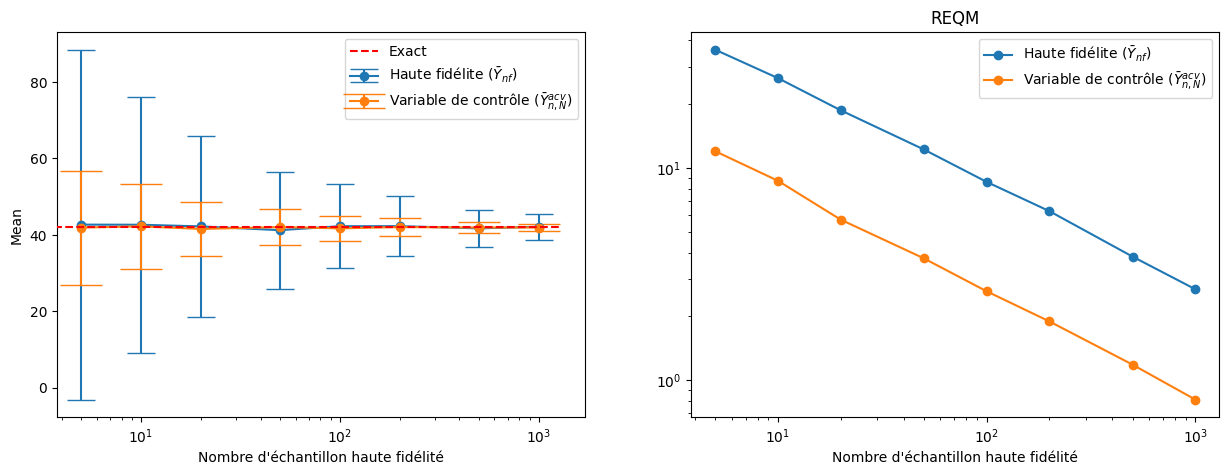

In [16]:
label_hf = 'Haute fidélite ($\\bar{Y}_{nf}$)'
label_acv = 'Variable de contrôle ($\\bar{Y}_{n,N}^{acv}$)'
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.errorbar(budgets, mean_Y_nf_par_budget, yerr=std_Y_nf_par_budget, label=label_hf, marker='o',capsize=10)
plt.errorbar(budgets, mean_Y_n_N_acv__par_budget, yerr=std_Y_n_N_acv__par_budget, label=label_acv, marker='o',capsize=15)
plt.hlines(mu_exact, 0, budgets[-1]+300, colors="red", linestyles="--", zorder=10, label="Exact")
plt.xlabel("Nombre d'échantillon haute fidélité")
plt.xscale('log')
plt.ylabel('Mean')
plt.legend()
plt.subplot(1, 2, 2)
plt.title("REQM")
plt.loglog(budgets, REQM_Y_nf, marker="o", label=label_hf)
plt.loglog(budgets, REQM_Y_n_N_acv, marker="o", label=label_acv)
plt.xlabel("Nombre d'échantillon haute fidélité")
plt.legend()
plt.show()

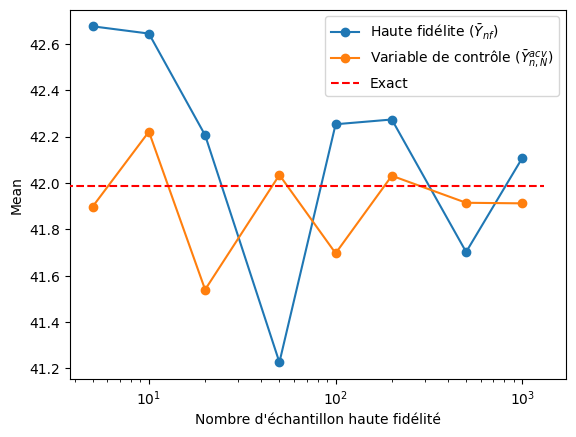

In [15]:
plt.figure()
plt.plot(budgets, mean_Y_nf_par_budget, label=label_hf, marker="o")
plt.plot(budgets, mean_Y_n_N_acv__par_budget, label=label_acv, marker="o")
plt.hlines(mu_exact, 0, budgets[-1]+300, colors="red", linestyles="--", zorder=10, label="Exact")
plt.xlabel("Nombre d'échantillon haute fidélité")
plt.xscale('log')
plt.ylabel('Mean')
plt.legend()
plt.show()

In [ ]:
nr = 200
budgets = [10, 20, 50, 100, 200, 1000, 2000, 5000, 10000]